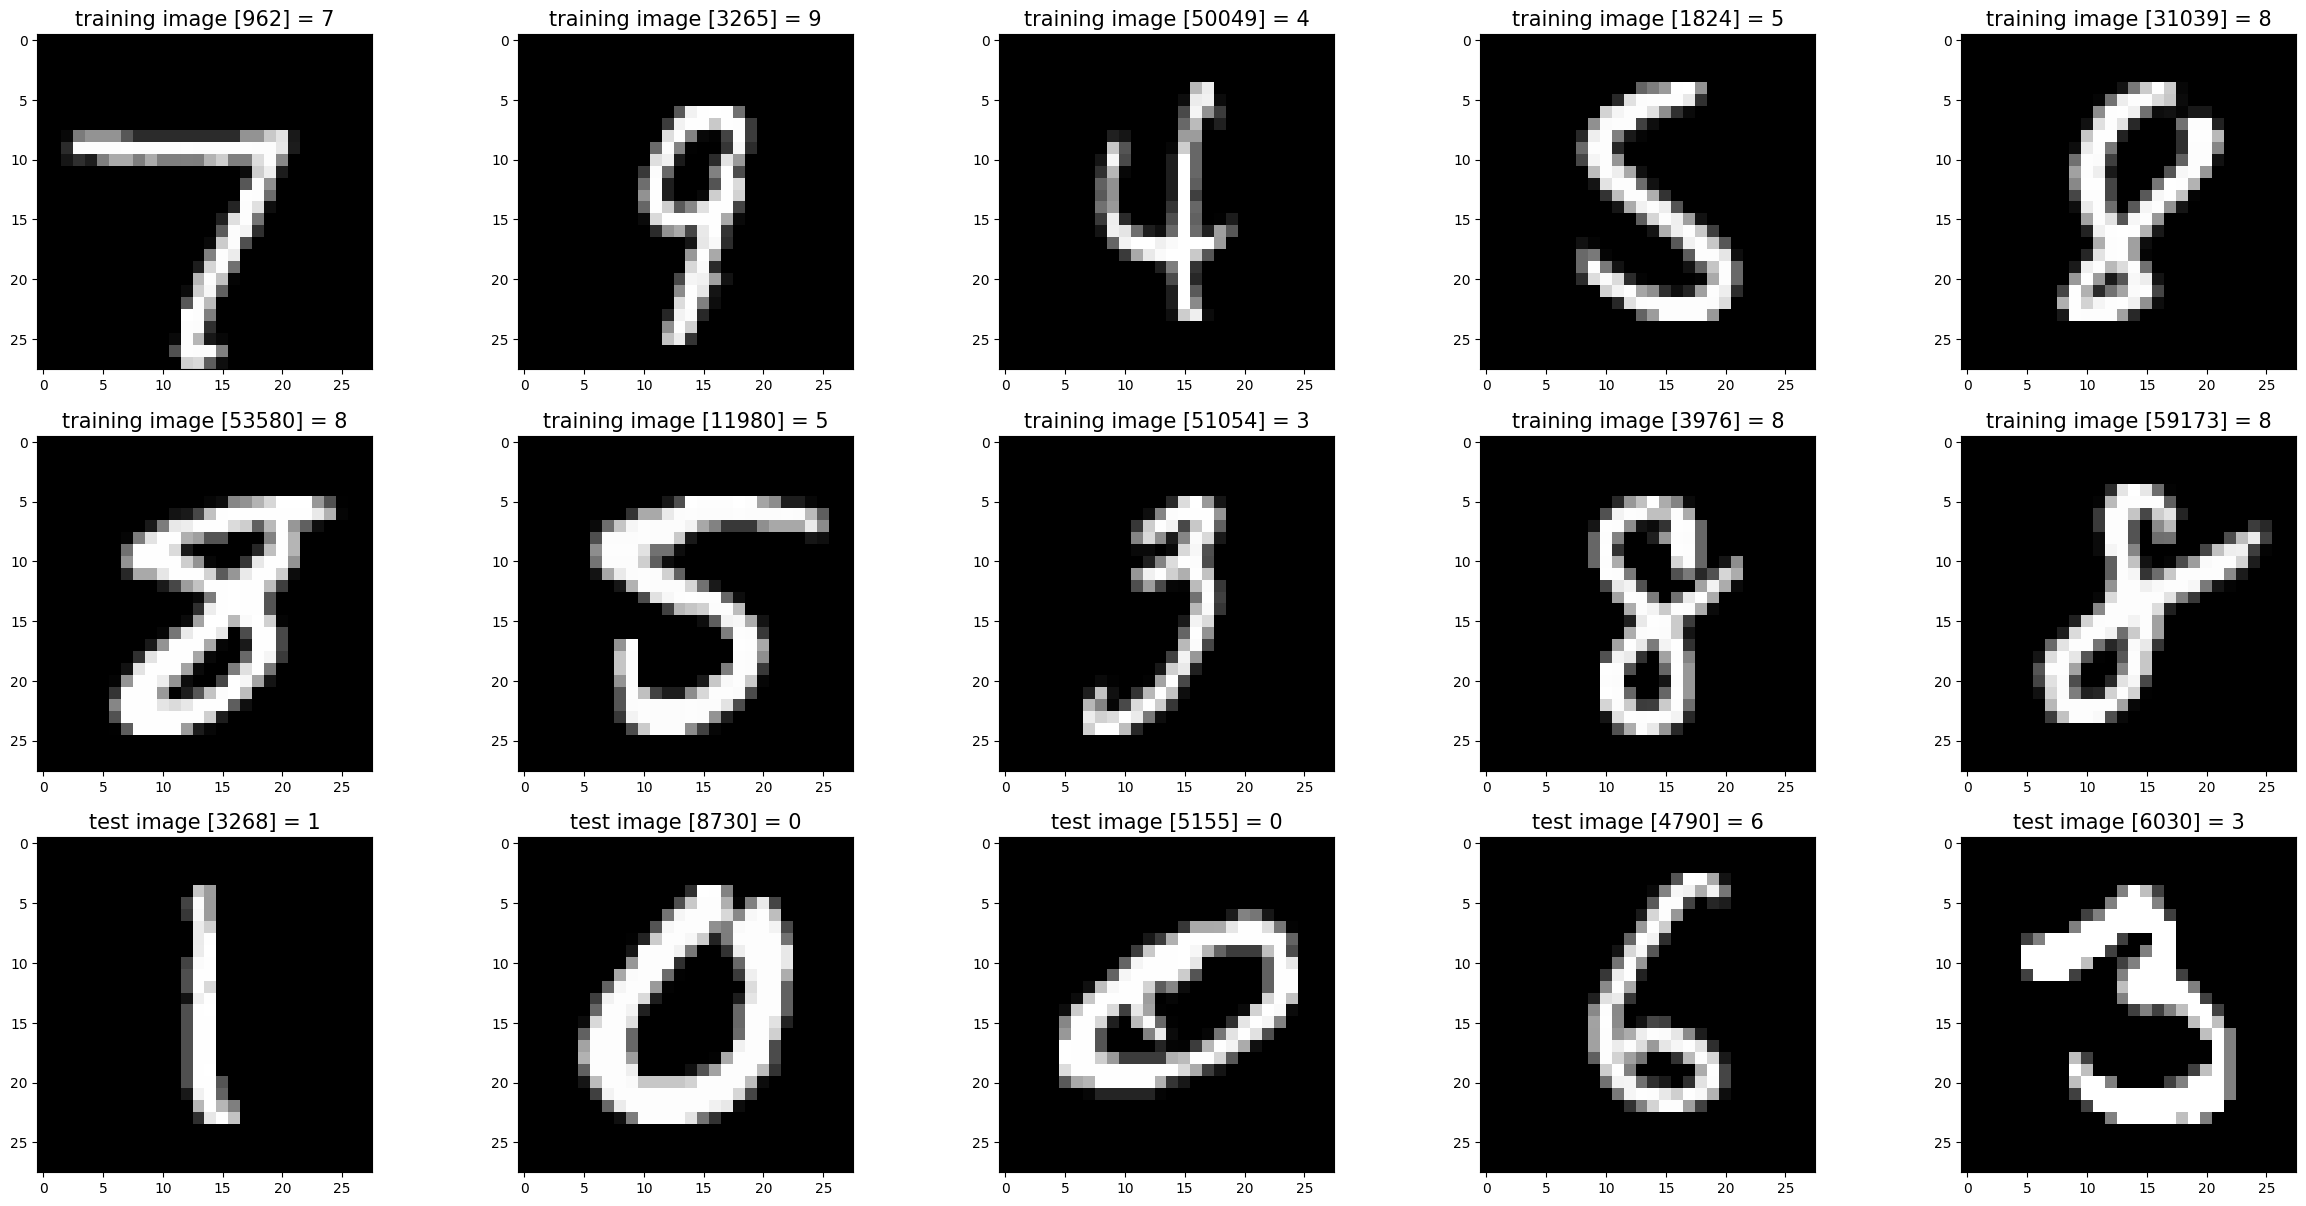

In [2]:
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test) 




# Verify Reading Dataset via MnistDataloader class

import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = './input'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images.idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels.idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images.idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels.idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(xo_train, yo_train), (xo_test, yo_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(xo_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(yo_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(xo_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(yo_test[r]))    

show_images(images_2_show, titles_2_show)

In [3]:
# Ensure they are NumPy arrays
x_train, y_train, x_test, y_test = map(np.array, (xo_train, yo_train, xo_test, yo_test))


x_train = x_train.reshape(-1, 784, 1) / 255  # Reshape to (num_samples, 784, 1), essentially makes everything column vectors
y_train = y_train.reshape(-1, 1)    #Answers are just a list of numbers 1-10
x_test = x_test.reshape(-1, 784, 1) / 255
y_test = y_test.reshape(-1, 1)

# Verify they have the correct number of samples
assert len(x_train) == len(y_train), f"Mismatch: X_train={len(x_train)}, Y_train={len(y_train)}"
assert len(x_test) == len(y_test), f"Mismatch: X_test={len(x_test)}, Y_test={len(y_test)}"

In [21]:
import numpy as np

class MLP:
    def __init__(self, layers):
        self.layers = layers
        self.weights = [np.random.randn(layers[i], layers[i - 1]) * np.sqrt(1 / layers[i - 1]) for i in range(1, len(layers))]
        self.biases = [np.zeros((layers[i], 1)) for i in range(1, len(layers))]

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x))  # For numerical stability
        return exp_x / exp_x.sum(axis=0, keepdims=True)

    def one_hot_encode(self, labels, num_classes=10):
        encoded = np.zeros((num_classes, labels.shape[0]))
        encoded[labels.flatten(), np.arange(labels.shape[0])] = 1
        return encoded

    def forward(self, X):
        activations = [X]
        for W, b in zip(self.weights[:-1], self.biases[:-1]):
            X = self.sigmoid(np.dot(W, X) + b)
            activations.append(X)
        X = self.softmax(np.dot(self.weights[-1], X) + self.biases[-1])  # Softmax on output layer
        activations.append(X)
        return activations

    def backward(self, X, Y, activations, learning_rate):
        deltas = [activations[-1] - Y]  # Cross-entropy loss gradient

        for i in range(len(self.weights) - 1, 0, -1):
            deltas.insert(0, np.dot(self.weights[i].T, deltas[0]) * self.sigmoid_derivative(activations[i]))

        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * np.dot(deltas[i], activations[i].T)
            self.biases[i] -= learning_rate * deltas[i]

    def train(self, X_train, Y_train, X_test, Y_test, epochs, learning_rate):
        Y_train_encoded = self.one_hot_encode(Y_train, num_classes=10)
        for epoch in range(epochs):
            for i in range(X_train.shape[0]):
                activations = self.forward(X_train[i])
                self.backward(X_train[i], Y_train_encoded[:, i].reshape(-1, 1), activations, learning_rate)

            
            accuracy = self.evaluate(X_test, Y_test)
            print(f"Epoch {epoch}, Accuracy: {float(accuracy):.4f}")

    def evaluate(self, X_test, Y_test):
        correct = sum(np.argmax(self.predict(X_test[i])) == Y_test[i] for i in range(len(X_test)))
        return correct / len(X_test)

    def predict(self, X):
        return self.forward(X)[-1]


In [22]:
from PIL import Image

np.random.seed(42)
mlp = MLP([784, 128, 64, 10])

img = Image.open('eight.bmp').convert("L")  # 'L' mode ensures grayscale
img_array = np.array(img)
img_array = img_array.flatten().reshape(-1, 1)
prediction = mlp.predict(img_array)
print(prediction)
print("Prediction:", np.argmax(prediction))



#Let's see if it can actually predict after training
mlp.train(x_train, y_train, x_test, y_test, epochs=6, learning_rate=0.01)
prediction = mlp.predict(img_array)
print(prediction)
print("Prediction:", np.argmax(prediction))



[[0.14536523]
 [0.1224428 ]
 [0.0958767 ]
 [0.05371731]
 [0.07863739]
 [0.10683886]
 [0.1638092 ]
 [0.08748342]
 [0.12288267]
 [0.02294643]]
Prediction: 6
Epoch 0, Accuracy: 0.9181
Epoch 1, Accuracy: 0.9417
Epoch 2, Accuracy: 0.9540
Epoch 3, Accuracy: 0.9607
Epoch 4, Accuracy: 0.9657
Epoch 5, Accuracy: 0.9695
[[5.46862457e-07]
 [4.48248033e-03]
 [7.43630016e-04]
 [4.52691628e-01]
 [1.16137126e-06]
 [7.59042321e-04]
 [3.34395159e-08]
 [1.29745736e-06]
 [5.41165016e-01]
 [1.55164187e-04]]
Prediction: 8


/tmp/ipykernel_748/3298163570.py:10: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


I've been stuck for a while here, my output layer alaways seems to diverge to 0.99999.

Note: Yay I eventually was able to fix it. The issue was I wasn't "hot-encoding" my answers, so the MLP was doing nonsensical stuff when back-propagating. Also a bunch of other dumbass mistakes

It worked on the 8 picture I drew myself. The next highest guess was 3, which I suppose looks the most like 8.